# CIS 5450 Final Project: NYC Taxi Analysis

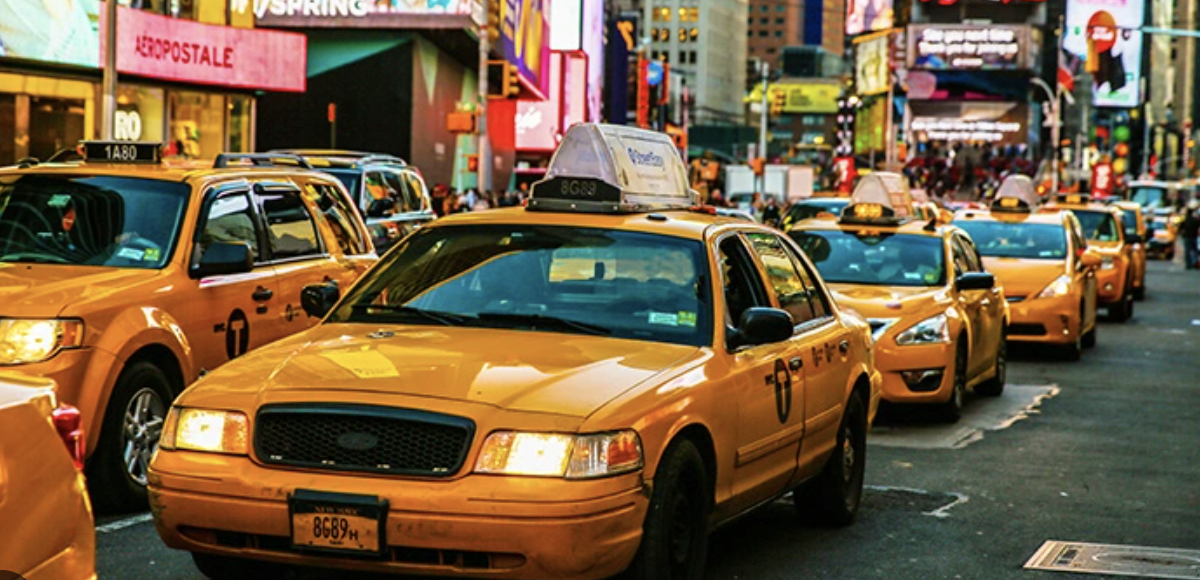

Welcome to our final project! We are Ashley Yan, Cindy Su, and Fiona Jiang, and our final project is on taxi data in New York City. We got our datasets from Kaggle, which can be found here: 
https://www.kaggle.com/datasets/neilclack/nyc-taxi-trip-data-google-public-data

For our project, we used two of the datasets: one is the original taxi dataset with all the features, and the other contains geological information on the taxi zones. In the original taxi dataset, each row represents a specific ride and contains many different columns, ranging from time to distance to tip amount. In the geological dataset, each row represents a zone ID and has columns detailing its name, borough, and geometric outline. We merged the geological dataset with the original dataset on zone ID so we could incorporate location in our analysis.

Our main goal is to be able to predict prices of taxi rides, and from these predictions gain more insight into how and which features affect price. The dataset contains 21 columns and about 8.3 million rows, so we ended up downsampling to 200,000 rows to reduce computational costs. We think that downsampling helps our analysis not only by reducing computation time but also reducing noise by naturally eliminating some outliers and less representative data points, leading to a cleaner and more accurate dataset. Thus, we used the downsampled dataset for the entirety of our project. 

We began our analysis by importing and merging the datasets, cleaning them by dropping null values, and doing some preliminary analysis to get basic info on the data. We then moved on to Exploratory Data Analysis (EDA), where we analyzed the features and their relationships with other variables. In this section, we made use of a variety of plots to better visualize patterns and interactions. After EDA, we moved onto modeling, where we started with a linear regression baseline model and explored several others based on which ones we thought were most appropriate for our data and objective. We also applied PCA and conducted unsupervised learning with KMeans clustering.  

# Data Preprocessing

In [1]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandasql as ps

In [2]:
#original taxi dataset
df = pd.read_csv('original_cleaned_nyc_taxi_data_2018.csv', index_col=0)

In [3]:
#downsampling to 200,000 rows
df = df.sample(n=200000, random_state=42).reset_index().drop(['index'], axis=1)

In [4]:
df.shape

(200000, 20)

In [5]:
df.head(5)

trip_distance  rate_code store_and_fwd_flag  payment_type  fare_amount  \
0           7.40          1                  Y             2         28.0   
1           9.00          1                  N             1         27.5   
2           7.80          1                  N             1         23.5   
3          11.78          1                  N             1         33.0   
4           8.43          1                  N             1         24.5   

   extra  mta_tax  tip_amount  tolls_amount  imp_surcharge  total_amount  \
0    0.5      0.5        0.00           0.0            0.3         29.30   
1    0.5      0.5        5.75           0.0            0.3         34.55   
2    0.5      0.5        3.72           0.0            0.3         28.52   
3    0.5      0.5        6.86           0.0            0.3         41.16   
4    0.0      0.5        2.00           0.0            0.3         27.30   

   pickup_location_id  dropoff_location_id  year  month  day  day_of_week  \
0                  48                   82  2018      3   27            1   
1                 261                  202  2018     12    3            0   
2                 186                  116  2018     10   17            2   
3                 138                   64  2018      5    4            4   
4                  13                  263  2018     11   12            0   

   hour_of_day  trip_duration  calculated_total_amount  
0            0         2876.0                    35.16  
1           22         2433.0                    47.47  
2            3         3469.0                    31.60  
3           23         1549.0                    30.35  
4           19         2702.0                    27.95

In [6]:
df.columns

Index(['trip_distance', 'rate_code', 'store_and_fwd_flag', 'payment_type',
       'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'imp_surcharge', 'total_amount', 'pickup_location_id',
       'dropoff_location_id', 'year', 'month', 'day', 'day_of_week',
       'hour_of_day', 'trip_duration', 'calculated_total_amount'],
      dtype='object')

In [7]:
#geological information dataset
geo_df = pd.read_csv('taxi_zone_geo.csv')

In [8]:
geo_df.head(5)

zone_id                zone_name borough  \
0        1           Newark Airport     EWR   
1        3  Allerton/Pelham Gardens   Bronx   
2       18             Bedford Park   Bronx   
3       20                  Belmont   Bronx   
4       31               Bronx Park   Bronx   

                                           zone_geom  
0  POLYGON((-74.1856319999999 40.6916479999999, -...  
1  POLYGON((-73.848596761 40.8716707849999, -73.8...  
2  POLYGON((-73.8844286139999 40.8668003789999, -...  
3  POLYGON((-73.8839239579998 40.8644177609999, -...  
4  POLYGON((-73.8710017319999 40.8572767429999, -...

In [9]:
geo_df['borough'].unique()

array(['EWR', 'Bronx', 'Queens', 'Brooklyn', 'Manhattan', 'Staten Island'],
      dtype=object)

In [10]:
#merging on pickup location ID using PandasSQL
query = """
SELECT * 
FROM df t
INNER JOIN geo_df t1 ON t.pickup_location_id = t1.zone_id
"""
joined_df = ps.sqldf(query, locals())
joined_df = joined_df.rename(columns={'zone_id': 'pickup_zone_id', 
                                      'zone_name' : 'pickup_zone_name', 
                                      'borough': 'pickup_borough', 
                                      'zone_geom' : 'pickup_zone_geom'}) 

In [11]:
#merging on dropoff location ID using PandasSQL
query = """
SELECT * 
FROM joined_df t
INNER JOIN geo_df t2 ON t.dropoff_location_id = t2.zone_id

"""
fdf = ps.sqldf(query, locals())
fdf = fdf.rename(columns={'zone_id': 'dropoff_zone_id', 
                          'zone_name' : 'dropoff_zone_name', 
                          'borough': 'dropoff_borough', 
                          'zone_geom' : 'dropoff_zone_geom'}) 

In [12]:
fdf.shape

(194374, 28)

In [13]:
fdf.head(5)

trip_distance  rate_code store_and_fwd_flag  payment_type  fare_amount  \
0           7.40          1                  Y             2         28.0   
1           9.00          1                  N             1         27.5   
2           7.80          1                  N             1         23.5   
3          11.78          1                  N             1         33.0   
4           8.43          1                  N             1         24.5   

   extra  mta_tax  tip_amount  tolls_amount  imp_surcharge  ...  \
0    0.5      0.5        0.00           0.0            0.3  ...   
1    0.5      0.5        5.75           0.0            0.3  ...   
2    0.5      0.5        3.72           0.0            0.3  ...   
3    0.5      0.5        6.86           0.0            0.3  ...   
4    0.0      0.5        2.00           0.0            0.3  ...   

   trip_duration  calculated_total_amount  pickup_zone_id  \
0         2876.0                    35.16              48   
1         2433.0                    47.47             261   
2         3469.0                    31.60             186   
3         1549.0                    30.35             138   
4         2702.0                    27.95              13   

               pickup_zone_name  pickup_borough  \
0                  Clinton East       Manhattan   
1            World Trade Center       Manhattan   
2  Penn Station/Madison Sq West       Manhattan   
3             LaGuardia Airport          Queens   
4             Battery Park City       Manhattan   

                                    pickup_zone_geom  dropoff_zone_id  \
0  POLYGON((-73.9907263629999 40.7559504059999, -...               82   
1  POLYGON((-74.013353098 40.7051985769998, -74.0...              202   
2  POLYGON((-73.9905176129999 40.7460386379999, -...              116   
3  MULTIPOLYGON(((-73.8728849699182 40.7859626331...               64   
4  POLYGON((-74.012554689 40.719069863, -74.01270...              263   

   dropoff_zone_name  dropoff_borough  \
0           Elmhurst           Queens   
1   Roosevelt Island        Manhattan   
2   Hamilton Heights        Manhattan   
3         Douglaston           Queens   
4     Yorkville West        Manhattan   

                                   dropoff_zone_geom  
0  POLYGON((-73.8678269109999 40.7446294569999, -...  
1  POLYGON((-73.941259753826 40.7693088793927, -7...  
2  POLYGON((-73.9389603489999 40.8289863299999, -...  
3  POLYGON((-73.7452105881078 40.7793265500935, -...  
4  POLYGON((-73.9518176159999 40.7735269039999, -...  

[5 rows x 28 columns]

In [14]:
fdf.columns

Index(['trip_distance', 'rate_code', 'store_and_fwd_flag', 'payment_type',
       'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'imp_surcharge', 'total_amount', 'pickup_location_id',
       'dropoff_location_id', 'year', 'month', 'day', 'day_of_week',
       'hour_of_day', 'trip_duration', 'calculated_total_amount',
       'pickup_zone_id', 'pickup_zone_name', 'pickup_borough',
       'pickup_zone_geom', 'dropoff_zone_id', 'dropoff_zone_name',
       'dropoff_borough', 'dropoff_zone_geom'],
      dtype='object')

In [15]:
fdf.dtypes

trip_distance              float64
rate_code                    int64
store_and_fwd_flag          object
payment_type                 int64
fare_amount                float64
extra                      float64
mta_tax                    float64
tip_amount                 float64
tolls_amount               float64
imp_surcharge              float64
total_amount               float64
pickup_location_id           int64
dropoff_location_id          int64
year                         int64
month                        int64
day                          int64
day_of_week                  int64
hour_of_day                  int64
trip_duration              float64
calculated_total_amount    float64
pickup_zone_id               int64
pickup_zone_name            object
pickup_borough              object
pickup_zone_geom            object
dropoff_zone_id              int64
dropoff_zone_name           object
dropoff_borough             object
dropoff_zone_geom           object
dtype: object

In [16]:
#checking for null values
fdf.isnull().sum()

trip_distance                  0
rate_code                      0
store_and_fwd_flag             0
payment_type                   0
fare_amount                    0
extra                          0
mta_tax                        0
tip_amount                     0
tolls_amount                   0
imp_surcharge                  0
total_amount                   0
pickup_location_id             0
dropoff_location_id            0
year                           0
month                          0
day                            0
day_of_week                    0
hour_of_day                    0
trip_duration                  0
calculated_total_amount    15608
pickup_zone_id                 0
pickup_zone_name               0
pickup_borough                 0
pickup_zone_geom               0
dropoff_zone_id                0
dropoff_zone_name              0
dropoff_borough                0
dropoff_zone_geom              0
dtype: int64

In [17]:
#dropping year since there's only one year
fdf = fdf.drop(columns=['year'])

In [18]:
#dropping null values, which is okay since we have a lot of data
fdf = fdf.dropna().reset_index().drop(['index'], axis=1)

In [19]:
fdf.shape

(178766, 27)

# Exploratory Data Analysis

### 1. Time Distribution 

We first analyzed the time distribution of rides by seeing how the number of rides vary across different days of the week and hours of the day. We also looked at monthly distribution and average trip distance by hour and day of the week. Finally, we looked at common pickup and dropoff locations during weekdays and weekends, and seeing how they vary. 

In [20]:
time_df = fdf.copy()

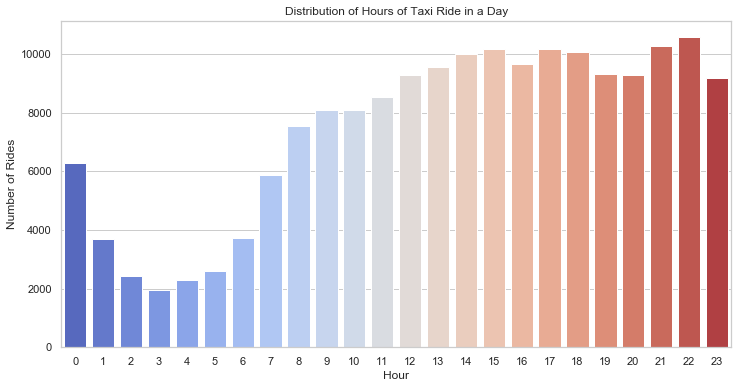

In [21]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.countplot(x='hour_of_day', data=time_df, palette="coolwarm")
plt.xlabel('Hour')
plt.ylabel('Number of Rides')
plt.title('Distribution of Hours of Taxi Ride in a Day')
plt.show()

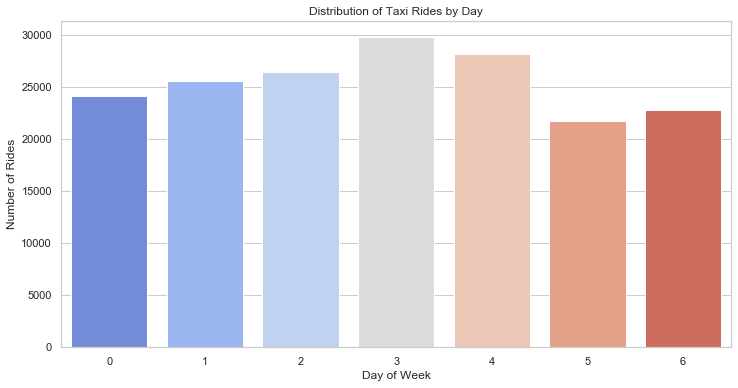

In [22]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.countplot(x='day_of_week', data=time_df, palette="coolwarm")
plt.xlabel('Day of Week')
plt.ylabel('Number of Rides')
plt.title('Distribution of Taxi Rides by Day')
plt.show()

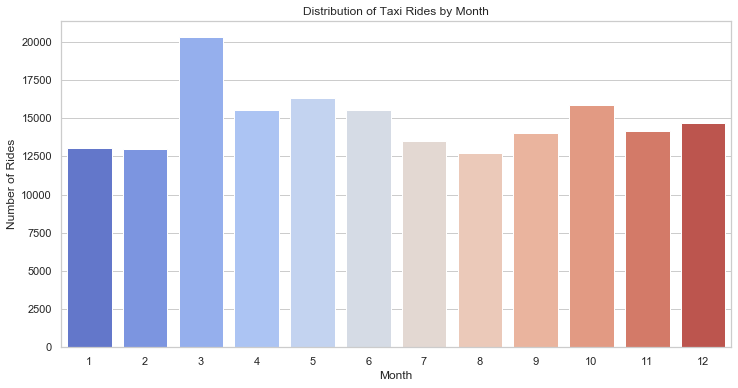

In [23]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.countplot(x='month', data=time_df, palette="coolwarm")
plt.xlabel('Month')
plt.ylabel('Number of Rides')
plt.title('Distribution of Taxi Rides by Month')
plt.show()

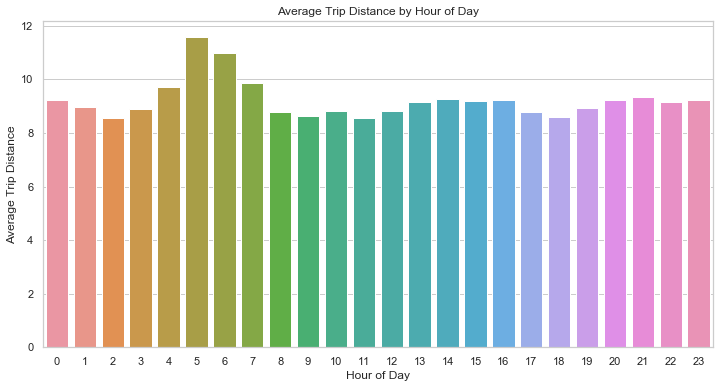

In [24]:
average_distance_by_hour = df.groupby('hour_of_day')['trip_distance'].mean().reset_index()
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(x='hour_of_day', y='trip_distance', data=average_distance_by_hour)
plt.xlabel('Hour of Day')
plt.ylabel('Average Trip Distance')
plt.title('Average Trip Distance by Hour of Day')
plt.show()

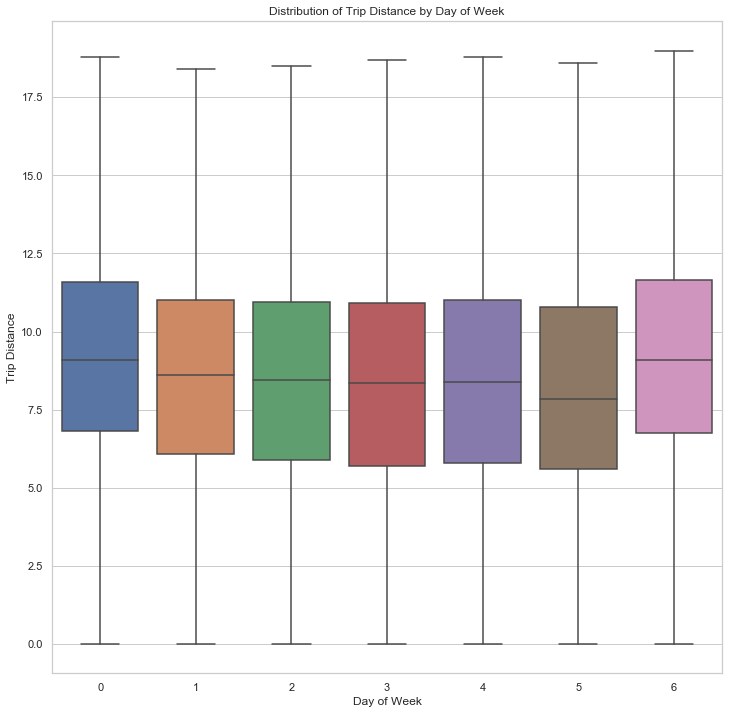

In [25]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 12))
sns.boxplot(x='day_of_week', y='trip_distance', data=time_df,sym="")
plt.xlabel('Day of Week')
plt.ylabel('Trip Distance')
plt.title('Distribution of Trip Distance by Day of Week')
plt.show()

In [26]:
#making separate subsets for weekdays and weekends
weekdays_df = time_df[time_df['day_of_week'] <= 4]
weekends_df = time_df[time_df['day_of_week'] > 4]

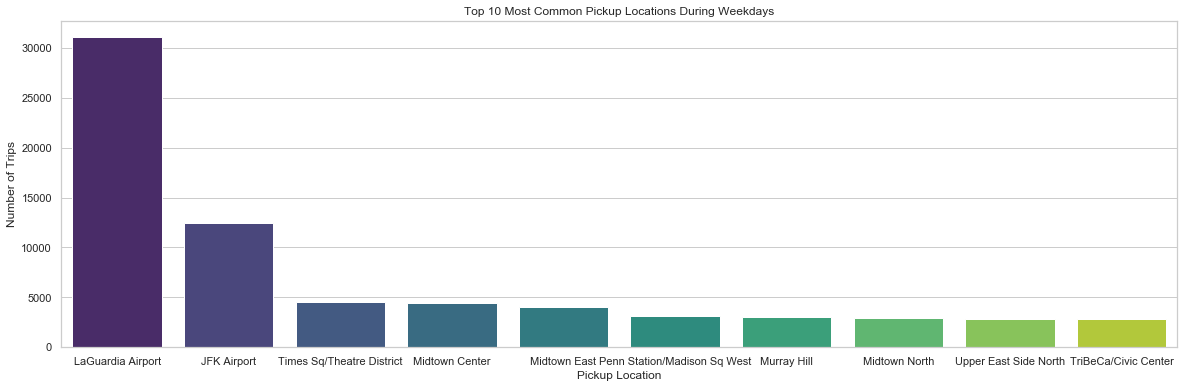

In [27]:
top_pickup_locations = weekdays_df['pickup_zone_name'].value_counts().head(10)
sns.set(style="whitegrid")
plt.figure(figsize=(20, 6))
sns.barplot(x=top_pickup_locations.index, y=top_pickup_locations.values, palette="viridis")
plt.xlabel('Pickup Location')
plt.ylabel('Number of Trips')
plt.title('Top 10 Most Common Pickup Locations During Weekdays')
plt.show()

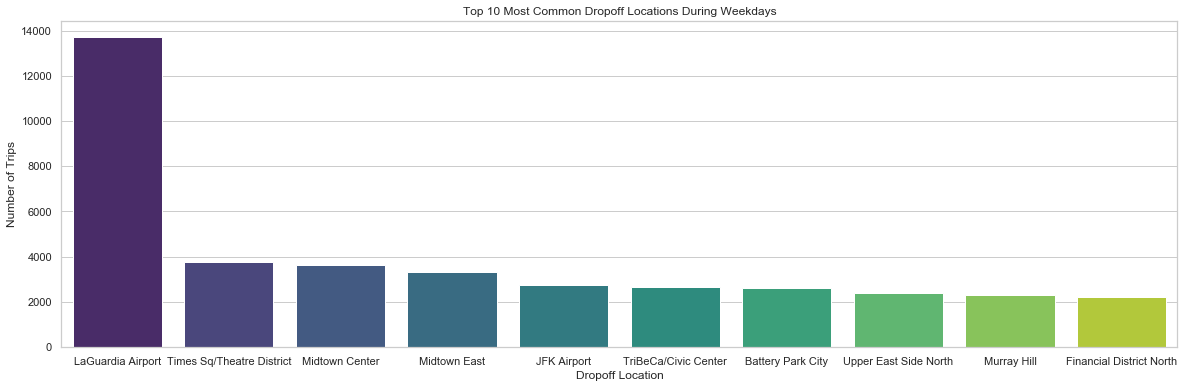

In [28]:
top_dropoff_locations = weekdays_df['dropoff_zone_name'].value_counts().head(10)
sns.set(style="whitegrid")
plt.figure(figsize=(20, 6))
sns.barplot(x=top_dropoff_locations.index, y=top_dropoff_locations.values, palette="viridis")
plt.xlabel('Dropoff Location')
plt.ylabel('Number of Trips')
plt.title('Top 10 Most Common Dropoff Locations During Weekdays')
plt.show()

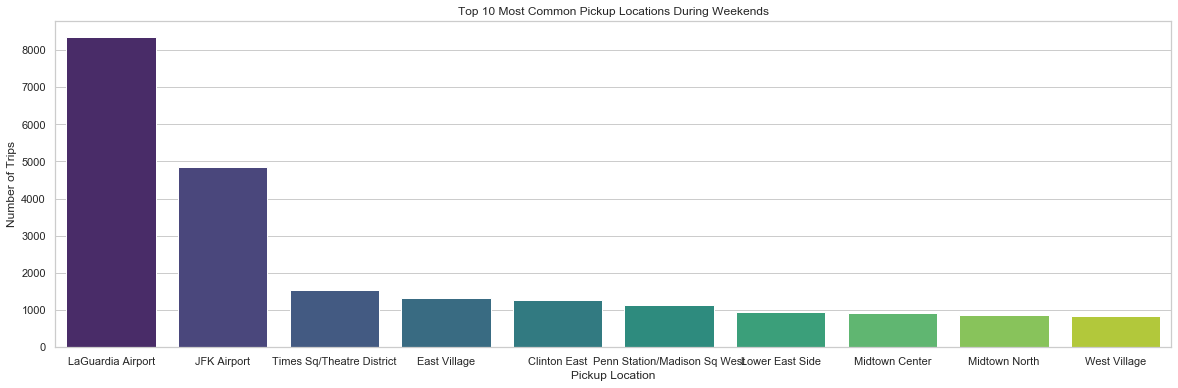

In [29]:
top_pickup_locations_weekends = weekends_df['pickup_zone_name'].value_counts().head(10)
sns.set(style="whitegrid")
plt.figure(figsize=(20, 6))
sns.barplot(x=top_pickup_locations_weekends.index, y=top_pickup_locations_weekends.values, palette="viridis")
plt.xlabel('Pickup Location')
plt.ylabel('Number of Trips')
plt.title('Top 10 Most Common Pickup Locations During Weekends')
plt.show()

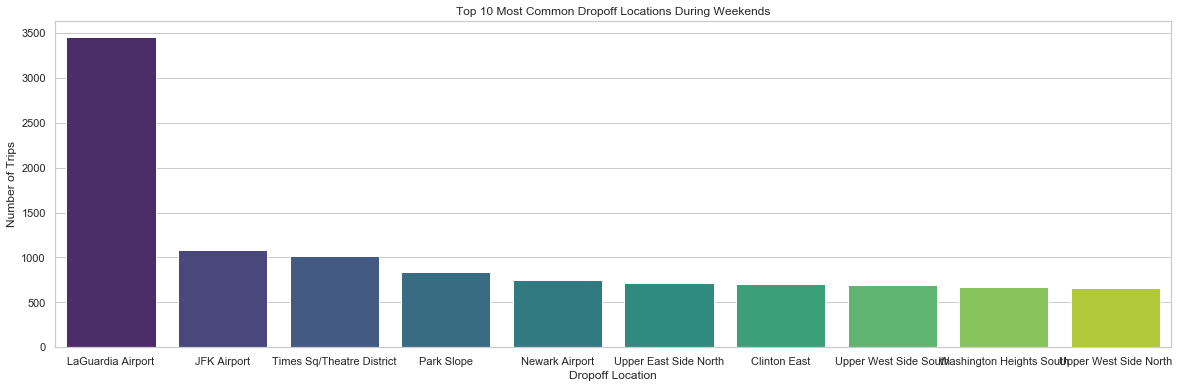

In [30]:
top_dropoff_locations_weekends = weekends_df['dropoff_zone_name'].value_counts().head(10)
sns.set(style="whitegrid")
plt.figure(figsize=(20, 6))
sns.barplot(x=top_dropoff_locations_weekends.index, y=top_dropoff_locations_weekends.values, palette="viridis")
plt.xlabel('Dropoff Location')
plt.ylabel('Number of Trips')
plt.title('Top 10 Most Common Dropoff Locations During Weekends')
plt.show()

### 2. Geographical Distribution 

Here we continued our analysis from above by further analyzing the geographical distribution of rides. Specifically, we the distribution of rides by borough, and conducted multivariable analysis by analyzing how they vary in terms of total price. We also looked into rate code and the distribution of some variables across different rate codes. Finally, we looked at the most frequent pickup and dropoff locations, as well as the most frequent routes. 

In [31]:
geodist_df = fdf.copy()

In [32]:
geodist_df.columns

Index(['trip_distance', 'rate_code', 'store_and_fwd_flag', 'payment_type',
       'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'imp_surcharge', 'total_amount', 'pickup_location_id',
       'dropoff_location_id', 'month', 'day', 'day_of_week', 'hour_of_day',
       'trip_duration', 'calculated_total_amount', 'pickup_zone_id',
       'pickup_zone_name', 'pickup_borough', 'pickup_zone_geom',
       'dropoff_zone_id', 'dropoff_zone_name', 'dropoff_borough',
       'dropoff_zone_geom'],
      dtype='object')

In [33]:
geodist_df = geodist_df[['pickup_zone_id', 'pickup_zone_name', 'pickup_borough', 'pickup_zone_geom', 
    'dropoff_zone_id',  'dropoff_zone_name',  'dropoff_borough', 'dropoff_zone_geom',
    'fare_amount', 'trip_distance']]

In [34]:
geodist_df.head(5)

pickup_zone_id              pickup_zone_name pickup_borough  \
0              48                  Clinton East      Manhattan   
1             261            World Trade Center      Manhattan   
2             186  Penn Station/Madison Sq West      Manhattan   
3             138             LaGuardia Airport         Queens   
4              13             Battery Park City      Manhattan   

                                    pickup_zone_geom  dropoff_zone_id  \
0  POLYGON((-73.9907263629999 40.7559504059999, -...               82   
1  POLYGON((-74.013353098 40.7051985769998, -74.0...              202   
2  POLYGON((-73.9905176129999 40.7460386379999, -...              116   
3  MULTIPOLYGON(((-73.8728849699182 40.7859626331...               64   
4  POLYGON((-74.012554689 40.719069863, -74.01270...              263   

  dropoff_zone_name dropoff_borough  \
0          Elmhurst          Queens   
1  Roosevelt Island       Manhattan   
2  Hamilton Heights       Manhattan   
3        Douglaston          Queens   
4    Yorkville West       Manhattan   

                                   dropoff_zone_geom  fare_amount  \
0  POLYGON((-73.8678269109999 40.7446294569999, -...         28.0   
1  POLYGON((-73.941259753826 40.7693088793927, -7...         27.5   
2  POLYGON((-73.9389603489999 40.8289863299999, -...         23.5   
3  POLYGON((-73.7452105881078 40.7793265500935, -...         33.0   
4  POLYGON((-73.9518176159999 40.7735269039999, -...         24.5   

   trip_distance  
0           7.40  
1           9.00  
2           7.80  
3          11.78  
4           8.43

In [35]:
#calculate pickup and dropoff borough counts
pickup_borough_counts = geodist_df.groupby('pickup_borough').size().reset_index(name='count')
dropoff_borough_counts = geodist_df.groupby('dropoff_borough').size().reset_index(name='count')
merged_borough_counts = pd.merge(pickup_borough_counts, dropoff_borough_counts, left_on='pickup_borough', right_on='dropoff_borough', suffixes=('_pickup', '_dropoff'))
merged_borough_counts

pickup_borough  count_pickup dropoff_borough  count_dropoff
0          Bronx           453           Bronx           5130
1       Brooklyn          3617        Brooklyn          32027
2            EWR            24             EWR           2899
3      Manhattan        115293       Manhattan         102090
4         Queens         59370          Queens          36367
5  Staten Island             9   Staten Island            253

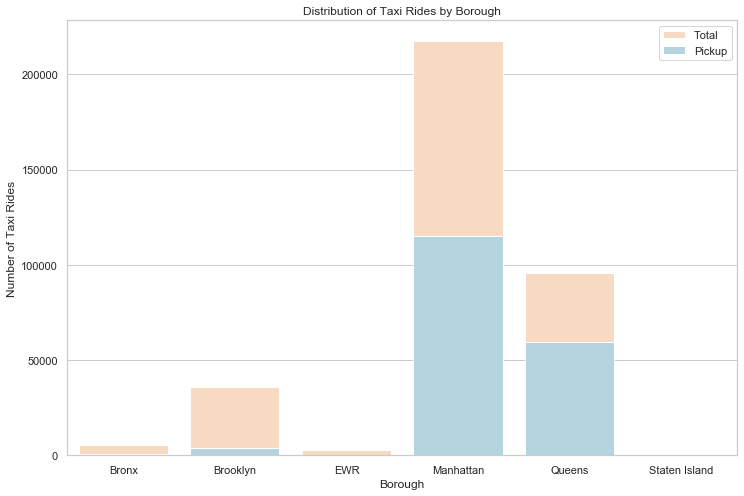

In [36]:
pickup_borough_counts = geodist_df.groupby('pickup_borough').size().reset_index(name='count_pickup')
dropoff_borough_counts = geodist_df.groupby('dropoff_borough').size().reset_index(name='count_dropoff')
merged_borough_counts = pd.merge(pickup_borough_counts, dropoff_borough_counts, left_on='pickup_borough', 
                                 right_on='dropoff_borough', suffixes=('_pickup', '_dropoff'))
merged_borough_counts.rename(columns={'pickup_borough': 'borough'}, inplace=True)
merged_borough_counts.drop(columns=['dropoff_borough'], inplace=True)
merged_borough_counts['total'] = merged_borough_counts['count_pickup'] + merged_borough_counts['count_dropoff']

plt.figure(figsize=(12, 8))
sns.barplot(x='borough', y='total', data=merged_borough_counts, color='peachpuff', label='Total')
sns.barplot(x='borough', y='count_pickup', data=merged_borough_counts, color='lightblue', label='Pickup')
plt.title('Distribution of Taxi Rides by Borough')
plt.xlabel('Borough')
plt.ylabel('Number of Taxi Rides')
plt.legend()
plt.show()

In [37]:
pickup_borough_counts

pickup_borough  count_pickup
0          Bronx           453
1       Brooklyn          3617
2            EWR            24
3      Manhattan        115293
4         Queens         59370
5  Staten Island             9

In [38]:
dropoff_borough_counts

dropoff_borough  count_dropoff
0           Bronx           5130
1        Brooklyn          32027
2             EWR           2899
3       Manhattan         102090
4          Queens          36367
5   Staten Island            253

In [39]:
amounts_by_pickup = fdf.groupby('pickup_borough')['total_amount'].mean().reset_index()
amounts_by_pickup

pickup_borough  total_amount
0          Bronx     41.292539
1       Brooklyn     36.321855
2            EWR    106.270833
3      Manhattan     35.225950
4         Queens     48.697257
5  Staten Island     55.337778

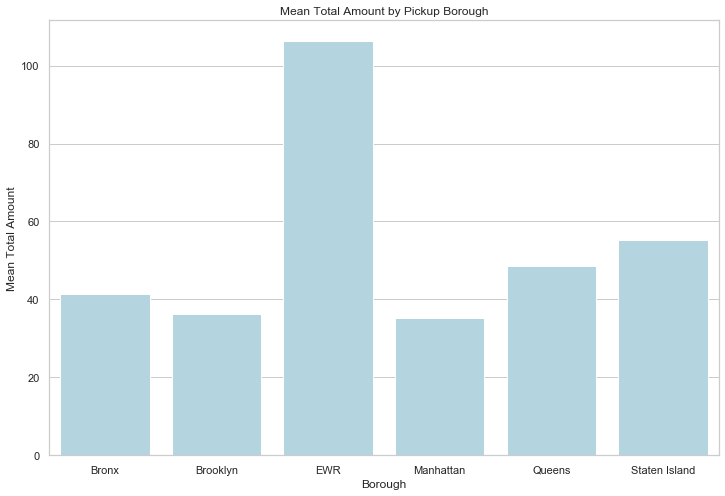

In [40]:
plt.figure(figsize=(12, 8))
sns.barplot(x='pickup_borough', y='total_amount', data=amounts_by_pickup, color='lightblue', label='Total')
plt.title('Mean Total Amount by Pickup Borough')
plt.xlabel('Borough')
plt.ylabel('Mean Total Amount')
plt.show()

In [41]:
#getting rid of an extreme outlier
max_value = fdf['total_amount'].max()
fdf = fdf.drop(fdf[fdf['total_amount'] == max_value].index)

In [42]:
fdf = fdf.reset_index().drop(['index'], axis=1)

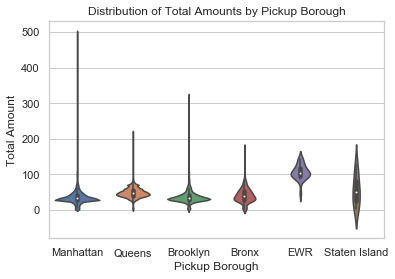

In [43]:
sns.violinplot(x='pickup_borough', y='total_amount', data=fdf)
plt.title('Distribution of Total Amounts by Pickup Borough')
plt.xlabel('Pickup Borough')
plt.ylabel('Total Amount')
plt.show()

In [44]:
amounts_by_dropoff = fdf.groupby('dropoff_borough')['total_amount'].mean().reset_index()
amounts_by_dropoff

dropoff_borough  total_amount
0           Bronx     43.319801
1        Brooklyn     40.977509
2             EWR    100.775609
3       Manhattan     35.715908
4          Queens     44.294181
5   Staten Island     83.705455

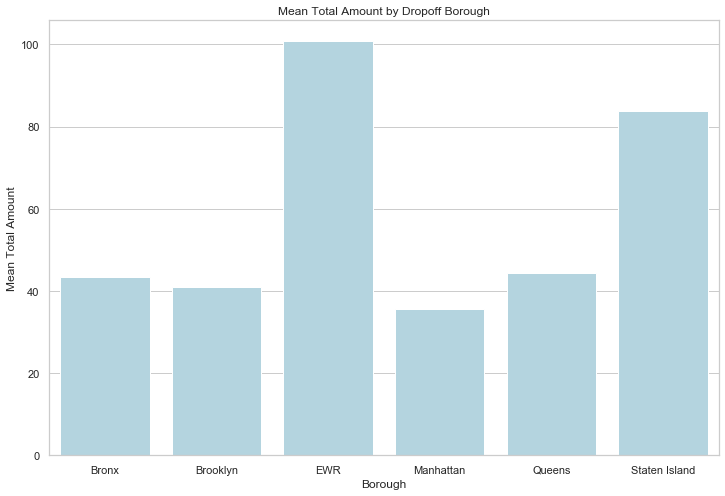

In [45]:
plt.figure(figsize=(12, 8))
sns.barplot(x='dropoff_borough', y='total_amount', data=amounts_by_dropoff, color='lightblue', label='Total')
plt.title('Mean Total Amount by Dropoff Borough')
plt.xlabel('Borough')
plt.ylabel('Mean Total Amount')
plt.show()

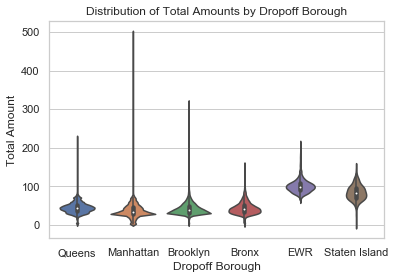

In [46]:
sns.violinplot(x='dropoff_borough', y='total_amount', data=fdf)
plt.title('Distribution of Total Amounts by Dropoff Borough')
plt.xlabel('Dropoff Borough')
plt.ylabel('Total Amount')
plt.show()

Rate codes:\
1 = Standard rate\
2 = JFK\
3 = Newark\
4 = Nassau or Westchester\
5 = Negotiated fare \
6 = Group ride

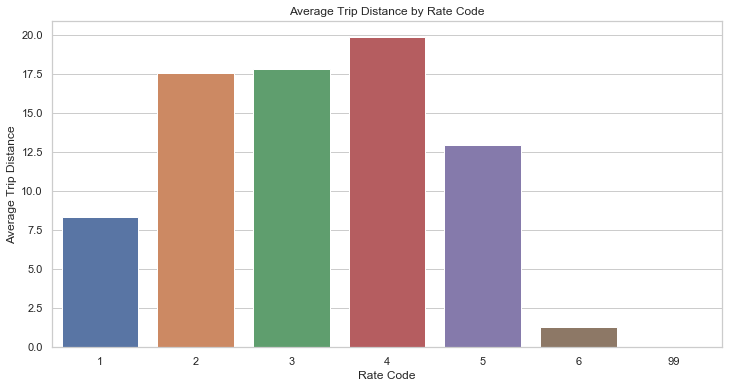

In [47]:
average_distance_by_rate_code = df.groupby('rate_code')['trip_distance'].mean().reset_index()
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(x='rate_code', y='trip_distance', data=average_distance_by_rate_code)
plt.xlabel('Rate Code')
plt.ylabel('Average Trip Distance')
plt.title('Average Trip Distance by Rate Code')
plt.show()

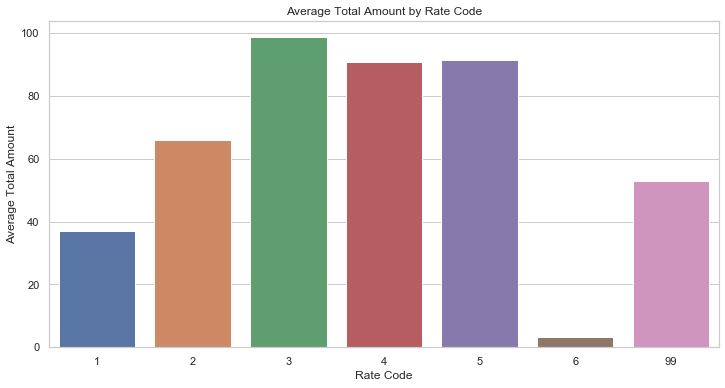

In [48]:
average_price_by_rate_code = df.groupby('rate_code')['total_amount'].mean().reset_index()
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(x='rate_code', y='total_amount', data=average_price_by_rate_code)
plt.xlabel('Rate Code')
plt.ylabel('Average Total Amount')
plt.title('Average Total Amount by Rate Code')
plt.show()

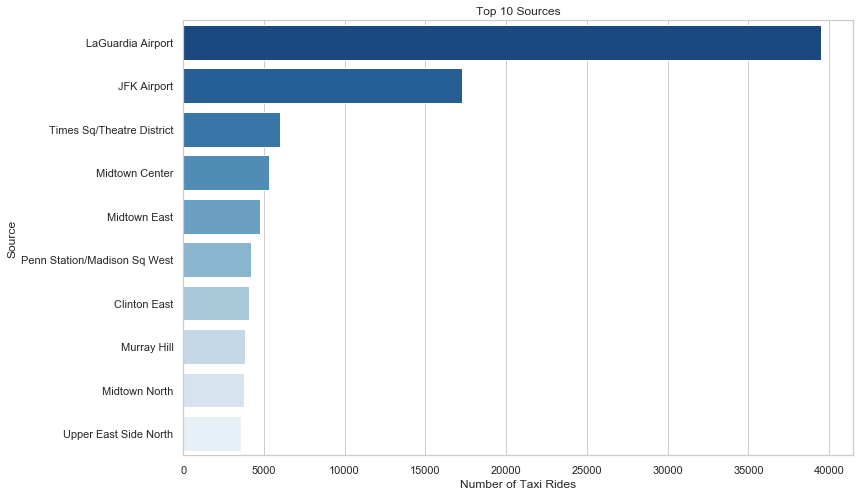

In [49]:
# Get top 10 sources
source_counts = geodist_df.groupby(['pickup_zone_name']).size().reset_index(name='count')
source_counts = source_counts.sort_values(by='count', ascending=False)
top_sources = source_counts.head(10)
plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='pickup_zone_name', data=top_sources, palette='Blues_r')
plt.title('Top 10 Sources')
plt.xlabel('Number of Taxi Rides')
plt.ylabel('Source')
plt.show()

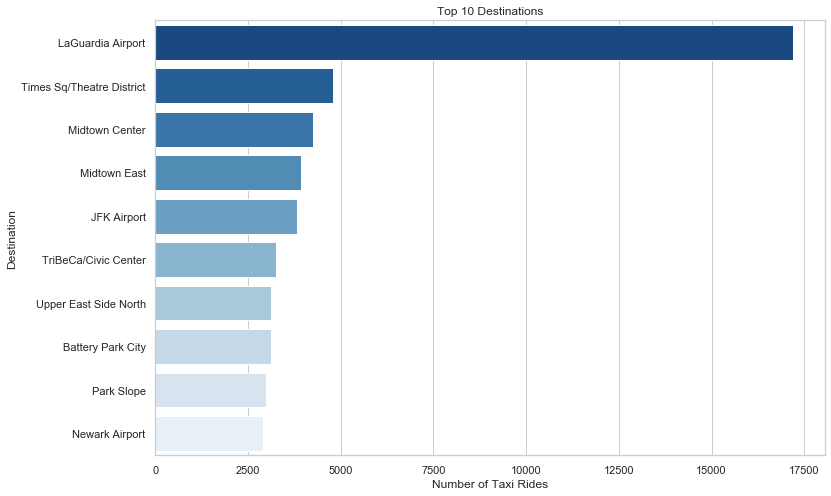

In [50]:
# Get top 10 destinations
dest_counts = geodist_df.groupby(['dropoff_zone_name']).size().reset_index(name='count')
dest_counts = dest_counts.sort_values(by='count', ascending=False)
top_dests = dest_counts.head(10)
plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='dropoff_zone_name', data=top_dests, palette='Blues_r')
plt.title('Top 10 Destinations')
plt.xlabel('Number of Taxi Rides')
plt.ylabel('Destination')
plt.show()

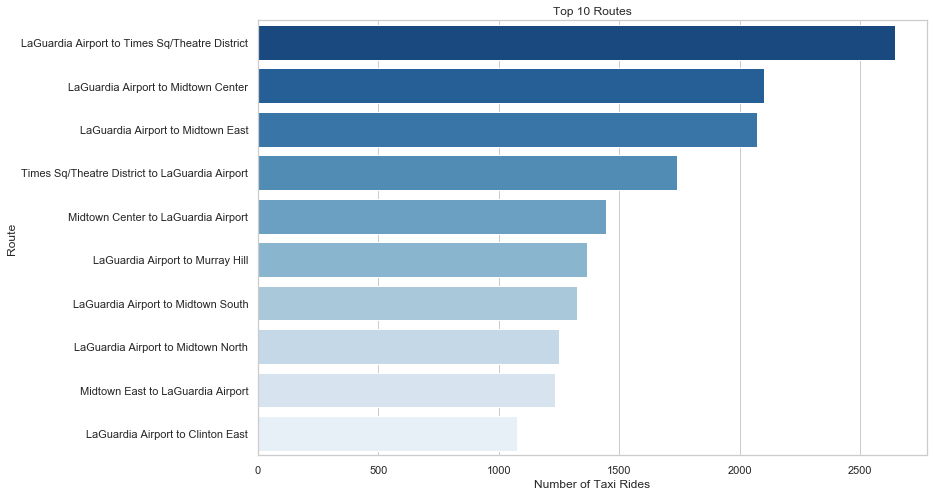

In [51]:
# Get top 10 routes by name
sd_counts2 = geodist_df.groupby(['pickup_zone_name', 'dropoff_zone_name']).size().reset_index(name='count')
sd_counts2 = sd_counts2.sort_values(by='count', ascending=False)
sd_counts2['route'] = sd_counts2['pickup_zone_name'] + ' to ' + sd_counts2['dropoff_zone_name']
sd_counts2.reset_index(drop=True, inplace=True)

top_routes = sd_counts2.head(10)
plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='route', data=top_routes, palette='Blues_r')
plt.title('Top 10 Routes')
plt.xlabel('Number of Taxi Rides')
plt.ylabel('Route')
plt.show()

### 3. Correlation Heatmap

Next, we plotted a correlation heatmap containing the correlations between every pair of numeric variables. We plotted two different types of correlation heatmaps, one for pearson coefficient and one for spearman. We wanted to plot both of these to first see how strong the linear relationship is between features (pearson), and then see how strong any sort of relationship is between features (spearman), not necessarily linear. 

In [52]:
fdf.dtypes

trip_distance              float64
rate_code                    int64
store_and_fwd_flag          object
payment_type                 int64
fare_amount                float64
extra                      float64
mta_tax                    float64
tip_amount                 float64
tolls_amount               float64
imp_surcharge              float64
total_amount               float64
pickup_location_id           int64
dropoff_location_id          int64
month                        int64
day                          int64
day_of_week                  int64
hour_of_day                  int64
trip_duration              float64
calculated_total_amount    float64
pickup_zone_id               int64
pickup_zone_name            object
pickup_borough              object
pickup_zone_geom            object
dropoff_zone_id              int64
dropoff_zone_name           object
dropoff_borough             object
dropoff_zone_geom           object
dtype: object

In [53]:
fdf_numeric = fdf.select_dtypes(include=['number'])

In [54]:
fdf_numeric.dtypes

trip_distance              float64
rate_code                    int64
payment_type                 int64
fare_amount                float64
extra                      float64
mta_tax                    float64
tip_amount                 float64
tolls_amount               float64
imp_surcharge              float64
total_amount               float64
pickup_location_id           int64
dropoff_location_id          int64
month                        int64
day                          int64
day_of_week                  int64
hour_of_day                  int64
trip_duration              float64
calculated_total_amount    float64
pickup_zone_id               int64
dropoff_zone_id              int64
dtype: object

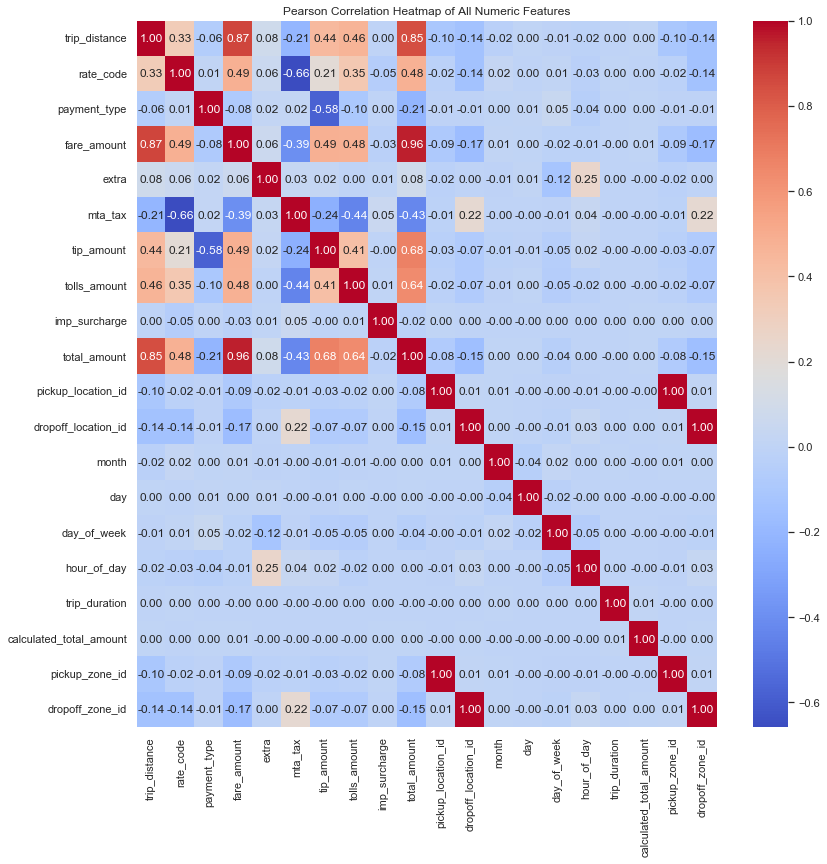

In [55]:
sns.set(style="white")
plt.figure(figsize=(13, 13))  
sns.heatmap(fdf_numeric.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Pearson Correlation Heatmap of All Numeric Features')
plt.show()

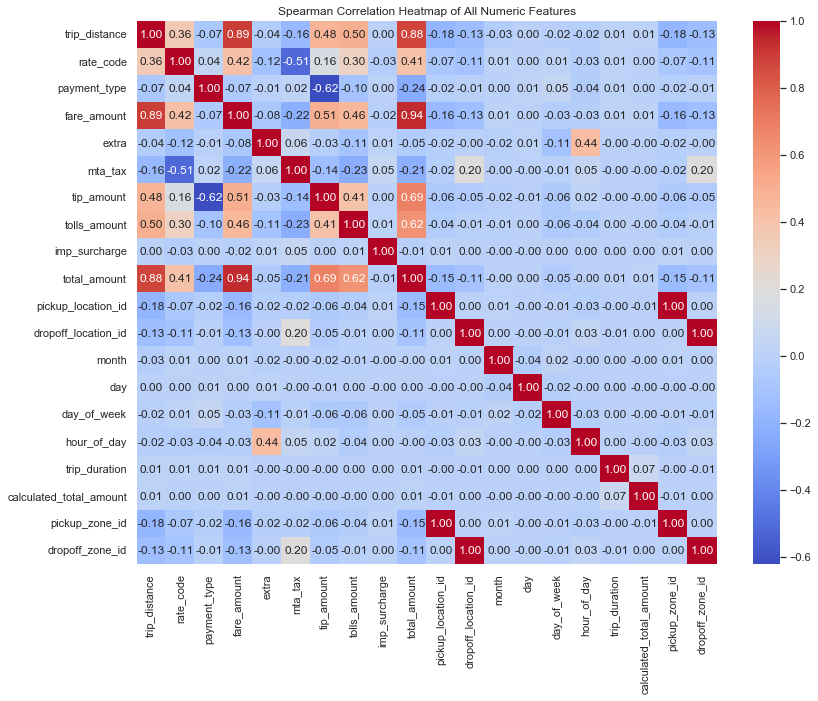

In [56]:
correlation_matrix = fdf_numeric.corr(method="spearman")
sns.set(style="white")
plt.figure(figsize=(13, 10))  
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Spearman Correlation Heatmap of All Numeric Features')
plt.show()

# Modeling

The next step of our project is modeling. We began with a simple linear regression model as the baseline model for numeric features, and then implemented regularization to help the model become more generalizable and address potential issues with multicolinearity. We then advanced to more complex models, including Random Forest, Neural Networks, and XGBoost, in order to incorporate categorical variables like pickup and dropoff location.

In [66]:
# import libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve

The columns we decided to include for our initial linear regression models were determined by our EDA findings and correlation values with the target variable and other features. We dropped several columns that had little to no correlation with total amount. We also dropped fare amount as it's essentially the same as total amount and from the correlation matrix we found high linear correlation with it, so it should not be used as a predictor. 

In [67]:
fdf_linear_modeling = fdf_numeric.drop(['fare_amount', 'payment_type', 'month', 'day', 'day_of_week', 
                                        'hour_of_day', 'extra', 'imp_surcharge', 'trip_duration',
                                        'calculated_total_amount', 'pickup_location_id', 'dropoff_location_id', 
                                        'pickup_zone_id', 'dropoff_zone_id'], axis=1)

In [68]:
fdf_linear_modeling.columns

Index(['trip_distance', 'rate_code', 'mta_tax', 'tip_amount', 'tolls_amount',
       'total_amount'],
      dtype='object')

In [69]:
X = fdf_linear_modeling.drop(['total_amount'], axis=1)
y = fdf_linear_modeling['total_amount']

Here we scaled our features and did an 80-20 split for training and testing sets. We thought scaling was necessary since the numeric features are on different scales, which would impact regularization on linear regression models like Lasso, Ridge, and Elastic Net. 

In [70]:
scaler = StandardScaler()

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [72]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [73]:
y_test = y_test.reset_index().drop(['index'], axis=1)
y_test

total_amount
0             42.06
1             41.00
2             50.09
3             58.87
4             54.07
...             ...
35748         29.30
35749          4.30
35750         45.06
35751         23.30
35752         27.80

[35753 rows x 1 columns]

## Linear Regression

We used a simple linear regression as a baseline model to initially see how the model would perform and provide direction for later models. We used RMSE and R^2 as evaluation metrics since it's a regression task. Based on the results, the RMSE is pretty low and R^2 is pretty high, indicating a decent initial fit for our baseline model. We think these results make sense since the numeric features, like trip distance and toll amount, would all be reasonably linearly correlated with total amount to some extent. 

In [74]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
y_pred_train = lr_model.predict(X_train)
print("Linear Regression testing RMSE = " + str(np.sqrt(mean_squared_error(y_pred, y_test['total_amount']))))
print("Linear Regression training RMSE = " + str(np.sqrt(mean_squared_error(y_pred_train, y_train))))
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

Linear Regression testing RMSE = 5.650193931892378
Linear Regression training RMSE = 5.495075208483562
R-squared: 0.8934906234674354


Here we plotted a subset of the predictions just to visualize how the predictions are looking relative to actual values. Based on the graph, the model is capturing changes in price pretty well, especially considering these predictions are on out-of-sample data. 

/Users/Fiona/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/range.py:839: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return super().__getitem__(key)


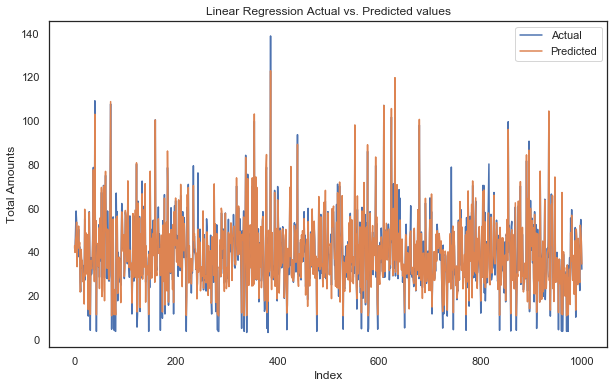

In [75]:
y_test_subset = y_test.iloc[:1000]
y_pred_subset = y_pred[:len(y_test_subset)]

plt.figure(figsize=(10, 6))
plt.xlabel('Index')
plt.plot(y_test_subset.index, y_test_subset, color='C0', label='Actual')
plt.plot(y_test_subset.index, y_pred_subset, color='C1', label='Predicted')
plt.ylabel('Total Amounts')
plt.title('Linear Regression Actual vs. Predicted values')
plt.legend()
plt.show()

In order to better understand how our baseline model is performing, we plotted the residuals of the predictions. The residual plot can help us identify unusual patterns in predictions, which can also provide more information on the types of relationships between variables (linear or nonlinear). For this model, it seems that the residuals are pretty randomly scattered, which indicates decent fit of linear regression on our numeric data. 

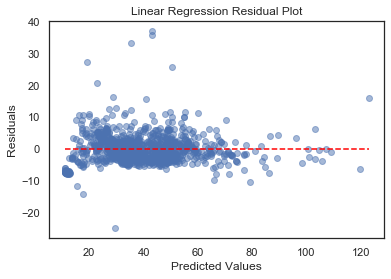

In [76]:
residuals = y_test_subset['total_amount'] - y_pred_subset

plt.scatter(y_pred_subset, residuals, alpha=0.5)
plt.title('Linear Regression Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.hlines(y=0, xmin=y_pred_subset.min(), xmax=y_pred_subset.max(), colors='red', linestyles='--')
plt.show()

## Regularization

In the next few models, we implemented different types of regularization to make our linear regression model more generalizable and less prone to overfitting. This does not imply that our baseline model is overfitting--we also just wanted to see if results would be much different with regularization.

### Lasso Regression

In [77]:
lasso_model = Lasso(alpha=0.5)
lasso_model.fit(X_train, y_train)
y_pred = lasso_model.predict(X_test)
y_pred_train = lasso_model.predict(X_train)
print("Lasso testing RMSE = " + str(np.sqrt(mean_squared_error(y_pred, y_test))))
print("Lasso training RMSE = " + str(np.sqrt(mean_squared_error(y_pred_train, y_train))))
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

Lasso testing RMSE = 5.8604644199112
Lasso training RMSE = 5.727740805072639
R-squared: 0.8854156775892756


### Ridge Regression

In [78]:
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)
y_pred = ridge_model.predict(X_test)
y_pred_train = ridge_model.predict(X_train)
print("Ridge testing RMSE = " + str(np.sqrt(mean_squared_error(y_pred, y_test))))
print("Ridge training RMSE = " + str(np.sqrt(mean_squared_error(y_pred_train, y_train))))
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

Ridge testing RMSE = 5.650097889470118
Ridge training RMSE = 5.495076283465636
R-squared: 0.8934942443454792


### Elastic Net

In [79]:
enet_model = ElasticNet()
enet_model.fit(X_train, y_train)
y_pred = enet_model.predict(X_test)
y_pred_train = enet_model.predict(X_train)
print("Elastic Net testing RMSE: " + str(np.sqrt(mean_squared_error(y_pred, y_test))))
print("Elastic Net training RMSE = " + str(np.sqrt(mean_squared_error(y_pred_train, y_train))))
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

Elastic Net testing RMSE: 6.144206937537763
Elastic Net training RMSE = 6.005576638370205
R-squared: 0.87405155717639


## Feature Engineering Categorical Variables
Our linear regression models seemed to perform decently, but we wanted to implement some more complex models to include the categorical features, like pickup and dropoff locations. Based on our EDA, there were definitely significant patterns between locations, which we captured in our models below. Before we implemented these models, we had to perform some feature engineering on the categorical variables. We did one-hot encoding for pickup borough and dropoff borough, but frequency encoding for pickup zone name and dropoff zone name due to the high number of unique pickup and dropoff locations. 

In [80]:
fdf.columns

Index(['trip_distance', 'rate_code', 'store_and_fwd_flag', 'payment_type',
       'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'imp_surcharge', 'total_amount', 'pickup_location_id',
       'dropoff_location_id', 'month', 'day', 'day_of_week', 'hour_of_day',
       'trip_duration', 'calculated_total_amount', 'pickup_zone_id',
       'pickup_zone_name', 'pickup_borough', 'pickup_zone_geom',
       'dropoff_zone_id', 'dropoff_zone_name', 'dropoff_borough',
       'dropoff_zone_geom'],
      dtype='object')

In [81]:
#here we selected the features we thought would be significant and relevant to price prediction
modeling_df = fdf[['trip_distance', 'rate_code', 'mta_tax', 'tip_amount', 'tolls_amount', 'trip_duration', 
                   'pickup_zone_name', 'pickup_borough', 'dropoff_zone_name', 'dropoff_borough', 'total_amount']]

In [82]:
#creating one-hot encoded columns for pickup and dropoff borough
ohe_df = pd.get_dummies(modeling_df, columns=['pickup_borough', 'dropoff_borough'], drop_first=True)
ohe_df

trip_distance  rate_code  mta_tax  tip_amount  tolls_amount  \
0                7.40          1      0.5        0.00          0.00   
1                9.00          1      0.5        5.75          0.00   
2                7.80          1      0.5        3.72          0.00   
3               11.78          1      0.5        6.86          0.00   
4                8.43          1      0.5        2.00          0.00   
...               ...        ...      ...         ...           ...   
178760           9.00          1      0.5        7.11          5.76   
178761           9.60          1      0.5        6.55          2.64   
178762          13.02          1      0.5        0.00          0.00   
178763           1.60          1      0.5        1.95          0.00   
178764           6.96          1      0.5        5.66          0.00   

        trip_duration              pickup_zone_name  \
0              2876.0                  Clinton East   
1              2433.0            World Trade Center   
2              3469.0  Penn Station/Madison Sq West   
3              1549.0             LaGuardia Airport   
4              2702.0             Battery Park City   
...               ...                           ...   
178760         2416.0             LaGuardia Airport   
178761         2340.0         Upper West Side North   
178762         1510.0       Two Bridges/Seward Park   
178763         3016.0         Upper West Side South   
178764         1402.0     Times Sq/Theatre District   

                          dropoff_zone_name  total_amount  \
0                                  Elmhurst         29.30   
1                          Roosevelt Island         34.55   
2                          Hamilton Heights         28.52   
3                                Douglaston         41.16   
4                            Yorkville West         27.30   
...                                     ...           ...   
178760             Washington Heights South         42.67   
178761  Riverdale/North Riverdale/Fieldston         39.49   
178762    University Heights/Morris Heights         40.30   
178763                        Midtown North         11.75   
178764                              Seaport         33.96   

        pickup_borough_Brooklyn  pickup_borough_EWR  pickup_borough_Manhattan  \
0                             0                   0                         1   
1                             0                   0                         1   
2                             0                   0                         1   
3                             0                   0                         0   
4                             0                   0                         1   
...                         ...                 ...                       ...   
178760                        0                   0                         0   
178761                        0                   0                         1   
178762                        0                   0                         1   
178763                        0                   0                         1   
178764                        0                   0                         1   

        pickup_borough_Queens  pickup_borough_Staten Island  \
0                           0                             0   
1                           0                             0   
2                           0                             0   
3                           1                             0   
4                           0                             0   
...                       ...                           ...   
178760                      1                             0   
178761                      0                             0   
178762                      0                             0   
178763                      0                             0   
178764                      0                             0   

        dropoff_borough_Brookly

In [83]:
X = ohe_df.drop(['total_amount'], axis=1)
y = ohe_df['total_amount']

In [84]:
#split dataset into training and testing sets with 80/20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [85]:
#applying frequency encoding on training and testing data separately to avoid data leakage
pickup_frequency_map = X_train['pickup_zone_name'].value_counts().to_dict()
dropoff_frequency_map = X_train['dropoff_zone_name'].value_counts().to_dict()

X_train['pickup_frequency'] = X_train['pickup_zone_name'].map(pickup_frequency_map)
X_train['dropoff_frequency'] = X_train['dropoff_zone_name'].map(dropoff_frequency_map)

X_test['pickup_frequency'] = X_test['pickup_zone_name'].map(pickup_frequency_map).fillna(0)
X_test['dropoff_frequency'] = X_test['dropoff_zone_name'].map(dropoff_frequency_map).fillna(0)

/Users/Fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/Fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/Fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [86]:
X_train = X_train.drop(['pickup_zone_name', 'dropoff_zone_name'], axis=1)
X_test = X_test.drop(['pickup_zone_name', 'dropoff_zone_name'], axis=1)

## Random Forest

We began with a Random Forest model because it helps capture nonlinear trends and can handle a large number of features, which is good for our engineered dataset since we have a few additional columns from one-hot encoding. We used GridSearch for hyperparameter tuning and found the optimal values of n_estimators and max_depth to be 200 and 20, respectively.

In [87]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf_regressor = RandomForestRegressor()
params = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30]
}
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=params, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)

/Users/Fiona/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


Fitting 3 folds for each of 9 candidates, totalling 27 fits


/Users/Fiona/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:32: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ._gradient_boosting import predict_stages
/Users/Fiona/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:32: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ._gradient_boosting 

Best parameters: {'max_depth': 20, 'n_estimators': 500}


In [88]:
rf_regressor = RandomForestRegressor(n_estimators=200, max_depth=20)
rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)
y_pred_train = rf_regressor.predict(X_train)

print("Random Forest testing RMSE = " + str(np.sqrt(mean_squared_error(y_pred, y_test))))
print("Random Forest training RMSE = " + str(np.sqrt(mean_squared_error(y_pred_train, y_train))))
r_squared = r2_score(y_test, y_pred)
print("R-squared:", r_squared)

/Users/Fiona/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/Users/Fiona/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the releas

Random Forest testing RMSE = 3.996867322717689
Random Forest training RMSE = 1.922249474047242
R-squared: 0.9469253956181337


Below we plotted subsets of predictions for both testing and training sets to visualize how well the model is performing. The training predictions seem to have slightly less fluctuations than the testing predictions, which makes intuitive sense. Also, the training RMSE is lower than the testing RMSE. Overall, Random Forest seems like a really good fit for our data. 

In [89]:
y_test_subset = y_test.iloc[:1000]
y_test_pred_subset = y_pred[:len(y_test_subset)]

results_df = pd.DataFrame({
    'Actual': y_test_subset,
    'Predicted': y_test_pred_subset
})

results_df = results_df.sort_values(by='Actual').reset_index(drop=True)

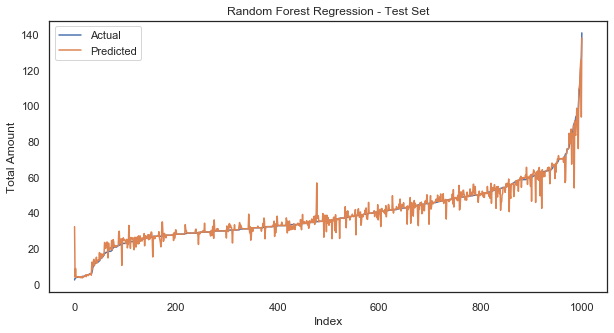

In [90]:
plt.figure(figsize=(10, 5))
plt.plot(results_df['Actual'], label='Actual', color='C0')
plt.plot(results_df['Predicted'], label='Predicted', color='C1')
plt.title('Random Forest Regression - Test Set')
plt.xlabel('Index')
plt.ylabel('Total Amount')
plt.legend()
plt.show()

In [91]:
y_train_subset = y_train.iloc[:1000]
y_train_pred_subset = y_pred_train[:len(y_train_subset)]

results_df = pd.DataFrame({
    'Actual': y_train_subset,
    'Predicted': y_train_pred_subset
})

results_df = results_df.sort_values(by='Actual').reset_index(drop=True)

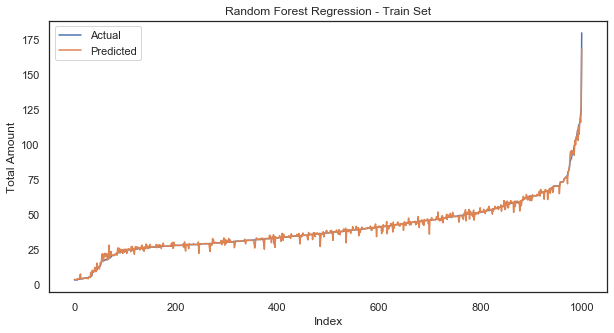

In [92]:
plt.figure(figsize=(10, 5))
plt.plot(results_df['Actual'], label='Actual', color='C0')
plt.plot(results_df['Predicted'], label='Predicted', color='C1')
plt.title('Random Forest Regression - Train Set')
plt.xlabel('Index')
plt.ylabel('Total Amount')
plt.legend()
plt.show()

Next we plotted the feature importances for Random Forest. Specifically, these feature importances represent how much each feature impacts the prediction. It seems that trip distance is the most important factor by far, followed by tip and toll amount. Due to one-hot encoding, it's difficult to see the impact of individual pickup and dropoff boroughs on the prediction. However, it does seem that the frequency of a location in the dataset doesn't impact the prediction very much, which is interesting since initially we thought that the popularity of a location would impact the average price of taxis in that location. 

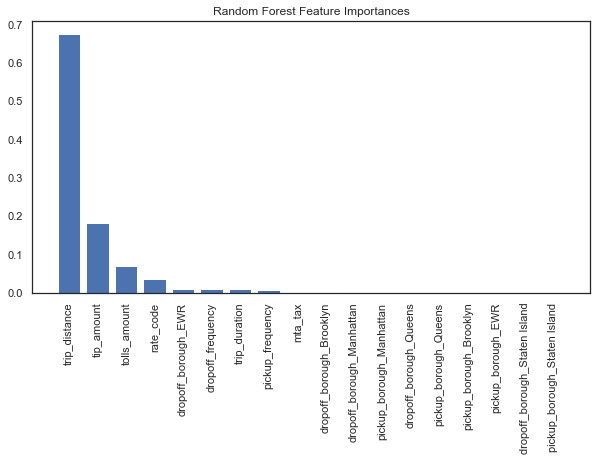

In [93]:
importances = rf_regressor.feature_importances_
feature_names = X_train.columns

indices = np.argsort(importances)[::-1]

names = [feature_names[i] for i in indices]

plt.figure(figsize=(10, 5))
plt.title("Random Forest Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), names, rotation=90)
plt.show()

## Neural Network
Here we choose Feedforward Neural Networks as our neural network model. FNN can offer several benefits for regression models. Since FNN can model complex non-linear relationships between input features and the target variable, this allows them to capture non-linear patterns in the data. Also, because of the neurons, it can also hangle high-dimensional data as well so that this would be a good choice as a foundational neural network. 

In [94]:
# import libraries
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import DataLoader, TensorDataset

In [95]:
# getting training and testing input values
X_train_nn = X_train.values
X_test_nn = X_test.values

In [96]:
# Normalize the input data
X_train_nn = StandardScaler().fit_transform(X_train_nn)
X_test_nn = StandardScaler().fit_transform(X_test_nn)

In [97]:
# getting the output values
y_train_nn = y_train.values
y_test_nn = y_test.values

We are constructing the FNN architecture as follows. We have two hidden layers: one with input size of 18 as output size of 15, another with input size of 15 and output size of 10. The last output layer has an input size of 10 and output size of 1, as the final prediction of total amount.

In [98]:
class FNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(X_train.shape[1], 15),
            nn.ReLU(),
            nn.Linear(15, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )


    def forward(self, x):
        x = self.flatten(x)
        outputs = self.linear_relu_stack(x)
        return outputs

In [99]:
FNN()

FNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=18, out_features=15, bias=True)
    (1): ReLU()
    (2): Linear(in_features=15, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [100]:
torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [103]:
X_train_tensor = torch.FloatTensor(X_train_nn)
y_train_tensor = torch.FloatTensor(y_train_nn)
X_test_tensor = torch.FloatTensor(X_test_nn)
y_test_tensor = torch.FloatTensor(y_test_nn)

In [104]:
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [132]:
%%time
fnn = FNN().to(device)
# set the loss criterion as Mean Squared Error Loss because this is a regression model
criterion = nn.MSELoss()
optimizer = optim.Adam(fnn.parameters(), lr=1e-4)
num_epochs = 15
loss_list = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = fnn(inputs)
        loss = criterion(outputs.squeeze(), labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    loss_list.append(avg_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss}")

print("Training finished.")

Epoch [1/15], Loss: 1718.32264628229
Epoch [2/15], Loss: 581.1862567773601
Epoch [3/15], Loss: 82.97697551821169
Epoch [4/15], Loss: 51.7765095119775
Epoch [5/15], Loss: 41.90105730137836
Epoch [6/15], Loss: 37.63712931255366
Epoch [7/15], Loss: 35.399315883115904
Epoch [8/15], Loss: 33.87762297730585
Epoch [9/15], Loss: 32.8349500472647
Epoch [10/15], Loss: 32.14388857037162
Epoch [11/15], Loss: 31.56389639254918
Epoch [12/15], Loss: 31.06932108151566
Epoch [13/15], Loss: 30.56874195798665
Epoch [14/15], Loss: 30.02042272896308
Epoch [15/15], Loss: 29.66583080633108
Training finished.
CPU times: user 19.9 s, sys: 11.2 s, total: 31.1 s
Wall time: 17.1 s


In [133]:
# Evaluating the model using RMSE
fnn.eval()
with torch.no_grad():
    predictions = fnn(X_test_tensor.to(device)).cpu().numpy()
print("Neural Network RMSE = " + str(np.sqrt(mean_squared_error(predictions, y_test))))

Neural Network RMSE = 5.53516824143499


In [134]:
# Evaluating the model using R^2
r2 = r2_score(y_test, predictions)
print(f"R-squared (R^2): {r2}")

R-squared (R^2): 0.8982091002261725


/Users/Fiona/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/Fiona/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/Fiona/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


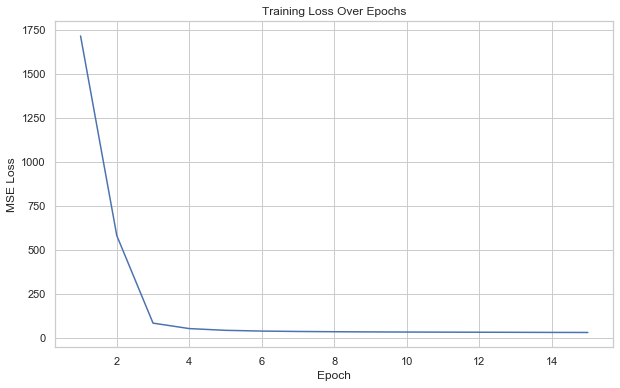

In [135]:
# Plot the MSE Loss for each epoch
data = {'Epoch': range(1, len(loss_list) + 1), 'Loss': loss_list}
df_loss = pd.DataFrame(data)
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x='Epoch', y='Loss', data=df_loss)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

### Hyperparameter Tuning
Here we are performing hyperparameter tuning using grid search. The parameters that we are testing are the learning rate, beta 1 and beta 2. For each model, we are going to run 10 epochs to see the result.

In [111]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'betas': [(0.9, 0.999), (0.95, 0.9995), (0.99, 0.9999)],
}
pgrid = ParameterGrid(param_grid)
num_epochs = 10

In [112]:
best_model = None
best_loss = float('inf')
best_params = None
for params in pgrid:
    fnn = FNN().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(fnn.parameters(), lr=params['learning_rate'], betas=params['betas'])

    print("Current param: "+ str(params))
    loss_list = []
    # Training loop
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
            optimizer.zero_grad()

        # Forward pass
            outputs = fnn(inputs)
            loss = criterion(outputs.squeeze(), labels)

        # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        loss_list.append(avg_loss)

    min_loss = min(loss_list)
    print("Current Loss: " + str(min_loss))

    if min_loss < best_loss:
        best_loss = min_loss
        best_model = fnn
        best_params = params
    print("best accuracy now: " + str(best_loss))

Current param: {'betas': (0.9, 0.999), 'learning_rate': 0.001}
Current Loss: 22.774125207990608
best accuracy now: 22.774125207990608
Current param: {'betas': (0.9, 0.999), 'learning_rate': 0.01}
Current Loss: 20.03417390550276
best accuracy now: 20.03417390550276
Current param: {'betas': (0.9, 0.999), 'learning_rate': 0.1}
Current Loss: 25.853198558798837
best accuracy now: 20.03417390550276
Current param: {'betas': (0.95, 0.9995), 'learning_rate': 0.001}
Current Loss: 22.550721125208025
best accuracy now: 20.03417390550276
Current param: {'betas': (0.95, 0.9995), 'learning_rate': 0.01}
Current Loss: 21.61910805030157
best accuracy now: 20.03417390550276
Current param: {'betas': (0.95, 0.9995), 'learning_rate': 0.1}
Current Loss: 25.552646457322226
best accuracy now: 20.03417390550276
Current param: {'betas': (0.99, 0.9999), 'learning_rate': 0.001}
Current Loss: 25.067018506777632
best accuracy now: 20.03417390550276
Current param: {'betas': (0.99, 0.9999), 'learning_rate': 0.01}
Curr

In [139]:
%%time
fnn = FNN().to(device)
# set the loss criterion as Mean Squared Error Loss because this is a regression model
criterion = nn.MSELoss()
optimizer = optim.Adam(fnn.parameters(), lr=best_params['learning_rate'], betas=best_params['betas'])
num_epochs = 15
loss_list = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = fnn(inputs)
        loss = criterion(outputs.squeeze(), labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    loss_list.append(avg_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss}")

print("Training finished.")

Epoch [1/15], Loss: 61.724394447318126
Epoch [2/15], Loss: 25.526457737916267
Epoch [3/15], Loss: 24.71158851649137
Epoch [4/15], Loss: 24.058440598225435
Epoch [5/15], Loss: 23.895501864516493
Epoch [6/15], Loss: 23.54863710648795
Epoch [7/15], Loss: 23.23187163116148
Epoch [8/15], Loss: 23.08244660204689
Epoch [9/15], Loss: 23.014967880419704
Epoch [10/15], Loss: 22.72224649966963
Epoch [11/15], Loss: 22.440674288107513
Epoch [12/15], Loss: 22.114115616459173
Epoch [13/15], Loss: 21.522004688612835
Epoch [14/15], Loss: 20.912711593875414
Epoch [15/15], Loss: 20.660984424403317
Training finished.
CPU times: user 19.8 s, sys: 11.2 s, total: 31.1 s
Wall time: 17 s


In [142]:
# Evaluating the model using RMSE
fnn.eval()
with torch.no_grad():
    predictions = fnn(X_test_tensor.to(device)).cpu().numpy()
print("Neural Network Testing RMSE = " + str(np.sqrt(mean_squared_error(predictions, y_test))))

Neural Network Testing RMSE = 4.527782570370121


In [141]:
# Evaluating the model using R^2
r2 = r2_score(y_test, predictions)
print(f"R-squared (R^2): {r2}")

R-squared (R^2): 0.9318888162302346


/Users/Fiona/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/Fiona/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/Fiona/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


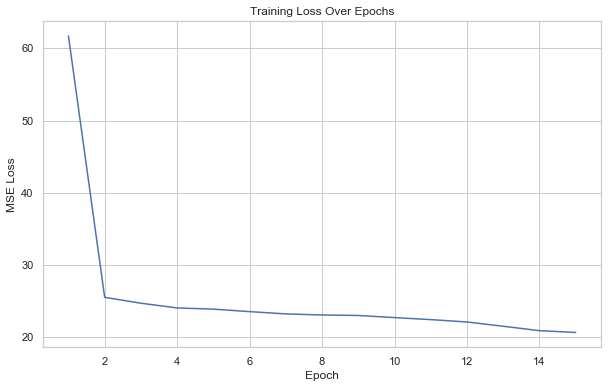

In [143]:
# Plot the MSE Loss for each epoch
data = {'Epoch': range(1, len(loss_list) + 1), 'Loss': loss_list}
df_loss = pd.DataFrame(data)
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x='Epoch', y='Loss', data=df_loss)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

In [144]:
# Plot the differences between actual and predicted data
y_test_r= y_test.values.reshape(-1, 1)
y_test_subset = y_test_r[:1000].flatten()
y_pred_subset = predictions[:len(y_test_subset)].flatten()
# y_test_subset = y_test.iloc[:1000]
# y_test_pred_subset = predictions[:len(y_test_subset)]
index_subset = range(len(y_test_subset))
results_df = pd.DataFrame({
    'Actual': y_test_subset,
    'Predicted': y_pred_subset
}, index=index_subset)

results_df = results_df.sort_values(by='Actual').reset_index(drop=True)

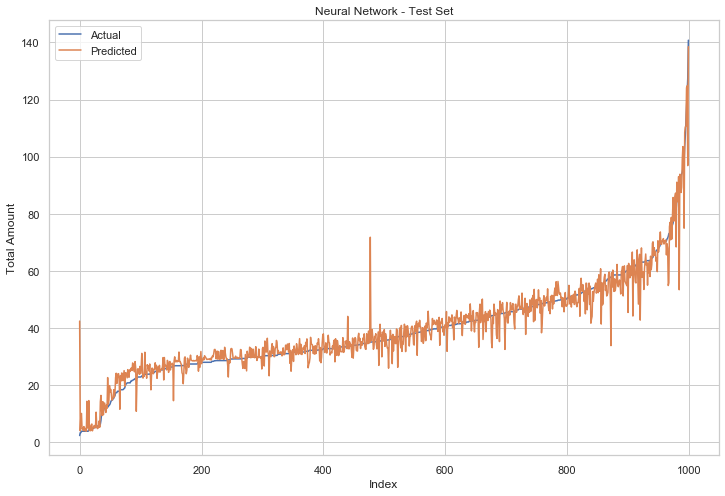

In [145]:
plt.figure(figsize=(12, 8))
plt.plot(results_df['Actual'], label='Actual', color='C0')
plt.plot(results_df['Predicted'], label='Predicted', color='C1')
plt.title('Neural Network - Test Set')
plt.xlabel('Index')
plt.ylabel('Total Amount')
plt.legend()
plt.show()

## XGBoost

The last model we tried was XGBoost Regressor. We tried this model because XGBoost works well with large and complex datasets, and includes regularization to prevent overfitting, which is important due to our additional columns from one-hot encoding the categorical variables. We used GridSearch to find the optimal parameters for n_estimators, learning_rate, and max_depth, which ended up being 500, 0.1, and 6, respectively. 

In [147]:
from xgboost import XGBRegressor
param_grid = {
    'n_estimators': [100, 250, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9]
}
xgb = XGBRegressor()
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


/Users/Fiona/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/Fiona/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated 

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learnin...
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    objective='reg:squarederror',
                                    predictor=None, random_state=None,
  

In [153]:
xgb_model = XGBRegressor(n_estimators=500,
                         learning_rate = 0.1,
                         max_depth = 6)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
y_pred_train = rf_regressor.predict(X_train)

print("XGBoost testing RMSE = " + str(np.sqrt(mean_squared_error(y_pred, y_test))))
print("XGBoost training RMSE = " + str(np.sqrt(mean_squared_error(y_pred_train, y_train))))
r_squared = r2_score(y_test, y_pred)
print("R-squared:", r_squared)

/Users/Fiona/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


XGBoost testing RMSE = 3.9041539491349475
XGBoost training RMSE = 1.922249474047242
R-squared: 0.9493591285394786


Just like for Random Forest, we plotted subsets of predictions for both testing and training sets. XGBoost Regression seems to be a similar fit to Random Forest, with very similar performance metrics.  

In [149]:
y_test_subset = y_test.iloc[:1000]
y_test_pred_subset = y_pred[:len(y_test_subset)]

results_df = pd.DataFrame({
    'Actual': y_test_subset,
    'Predicted': y_test_pred_subset
})

results_df = results_df.sort_values(by='Actual').reset_index(drop=True)

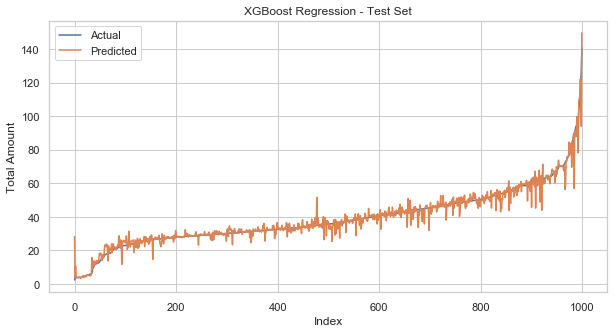

In [150]:
plt.figure(figsize=(10, 5))
plt.plot(results_df['Actual'], label='Actual', color='C0')
plt.plot(results_df['Predicted'], label='Predicted', color='C1')
plt.title('XGBoost Regression - Test Set')
plt.xlabel('Index')
plt.ylabel('Total Amount')
plt.legend()
plt.show()

In [151]:
y_train_subset = y_train.iloc[:1000]
y_train_pred_subset = y_pred_train[:len(y_train_subset)]

results_df = pd.DataFrame({
    'Actual': y_train_subset,
    'Predicted': y_train_pred_subset
})

results_df = results_df.sort_values(by='Actual').reset_index(drop=True)

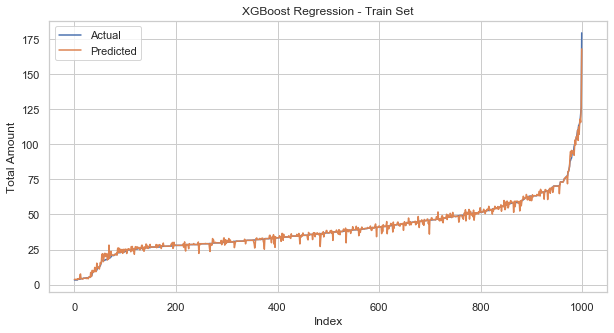

In [152]:
plt.figure(figsize=(10, 5))
plt.plot(results_df['Actual'], label='Actual', color='C0')
plt.plot(results_df['Predicted'], label='Predicted', color='C1')
plt.title('XGBoost Regression - Train Set')
plt.xlabel('Index')
plt.ylabel('Total Amount')
plt.legend()
plt.show()

# KMeans

In addition to supervised modeling, we also thought unsupervised modeling would be helpful in identifying some patterns and interactions between variables that are not so visible through just EDA. We decided to do KMeans, which we thought would be helpful for identifying groups of taxi riders with different characteristics, like generous tippers, long distance riders, and more. This part is especially important for our value proposition in which taxi companies can tailor their services based on consumer habits and patterns. 

In [154]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from scipy.stats import zscore

In [155]:
cluster_df = fdf.copy()

In [156]:
# Remove two indices with extreme values for fare price before clustering
cluster_df = cluster_df[cluster_df['fare_amount'] != 99618.22]
cluster_df = cluster_df[cluster_df['fare_amount'] != 187436.46]

In [157]:
# Select relevant columns for PCA
selected_columns = ['trip_distance', 'rate_code', 'payment_type', 'fare_amount', 'extra', 'mta_tax',
                    'tip_amount', 'tolls_amount', 'imp_surcharge', 'total_amount', 'pickup_location_id',
                    'dropoff_location_id', 'month', 'day', 'day_of_week', 'hour_of_day', 'trip_duration',
                    'calculated_total_amount', 'pickup_zone_id', 'dropoff_zone_id']

X = cluster_df[selected_columns]

Standardize the selected columns to have zero mean and unit variance. This step is important for PCA, as it ensures that all features contribute equally to the principal components.

In [158]:
# Standardize the data
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

Apply Principal Component Analysis (PCA) to reduce the dimensionality of the dataset. This transforms the original variables into a new set of principal components.

In [159]:
# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_std)

In [160]:
# Print the top principal components
n_top_components = 5  # Adjust as needed
top_components = pca.components_[:n_top_components, :]

# Display the top principal components
for i in range(n_top_components):
    print(f"Top Principal Component {i + 1}: {top_components[i]}")

Top Principal Component 1: [ 3.89574895e-01  2.96882941e-01 -1.12652112e-01  4.32817412e-01
  3.44593226e-02 -2.85494985e-01  3.19792964e-01  3.29081025e-01
 -1.46302121e-02  4.62161299e-01 -5.82278518e-02 -1.51402999e-01
 -1.29779065e-03  1.19942247e-03 -1.79623178e-02 -7.27651445e-03
  4.45149613e-04  1.04527500e-03 -5.82278518e-02 -1.51402999e-01]
Top Principal Component 2: [-0.07951127  0.08146004  0.03459207 -0.04001988 -0.05156227 -0.14712808
 -0.04601602  0.00739064 -0.00702484 -0.04183166  0.62050537 -0.30227301
  0.01156294 -0.00422733  0.01817    -0.05181242 -0.00157745 -0.00261564
  0.62050537 -0.30227301]
Top Principal Component 3: [ 0.0763821  -0.02314151 -0.18901266  0.06848839  0.03611668  0.07545177
  0.19699591  0.11821045  0.00398803  0.12158943  0.3196699   0.5778044
  0.00401788 -0.00307472 -0.05817186  0.05592486 -0.00123019  0.00179581
  0.3196699   0.5778044 ]
Top Principal Component 4: [ 0.01096127  0.37278187  0.58194995  0.07314549 -0.17631661 -0.32742272
 -0.

This plot shows how much information (variance) is retained as more principal components are included. We observe a curve where the rate of increase in explained variance decreases. At the beginning of the plot, the slope is steep, indicating that each additional principal component contributes significantly to explaining the variance. As you add more principal components, the curve starts to flatten, and the additional components contribute less to the total variance. The point at which this curve starts to flatten out can be used to consider the number of principal components to retain. The number of principal components corresponding to this elbow is a common criterion for selecting the optimal number of components.

/Users/Fiona/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/Fiona/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/Fiona/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


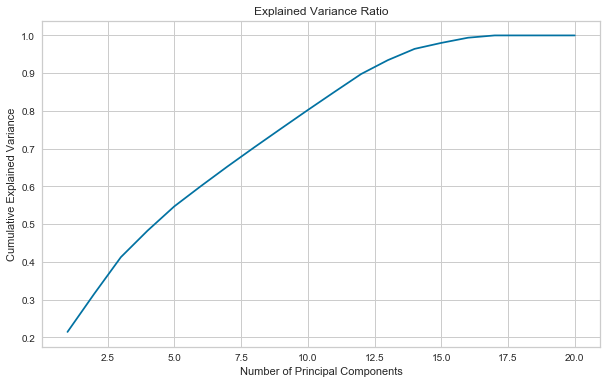

In [161]:
# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
sns.lineplot(x=np.arange(1, len(pca.explained_variance_ratio_) + 1), y=np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance Ratio')
# sns.set(font_scale=1.2) 
plt.show()

In [162]:
# Perform PCA with 10 components
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_std)

Use the elbow method to find the optimal number of clusters for K-means. The elbow represents a point where increasing the number of clusters provides diminishing returns in terms of explaining the variance.

/Users/Fiona/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Users/Fiona/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Users/Fiona/anaconda3/lib/python3.7/site-packag

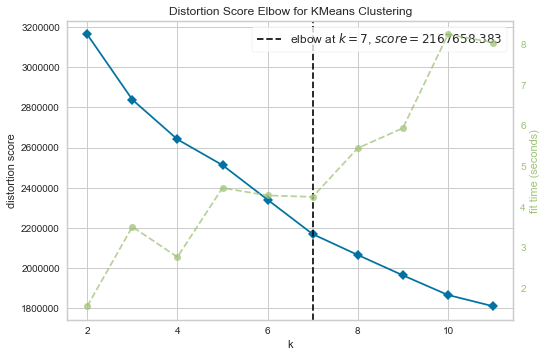

In [163]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 12))
visualizer.fit(X_std)
visualizer.show()

In [164]:
# Perform K-means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=8, random_state=42)
cluster_df['cluster'] = kmeans.fit_predict(X_std)

/Users/Fiona/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Users/Fiona/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Users/Fiona/anaconda3/lib/python3.7/site-packag

In [165]:
# Print the counts in each cluster
print(cluster_df['cluster'].value_counts())

1    48219
2    40035
4    38261
0    32639
5    15577
3     3371
7      644
6       19
Name: cluster, dtype: int64


In [166]:
cluster_df.shape

(178765, 28)

In [167]:
X_pca.shape

(178765, 10)

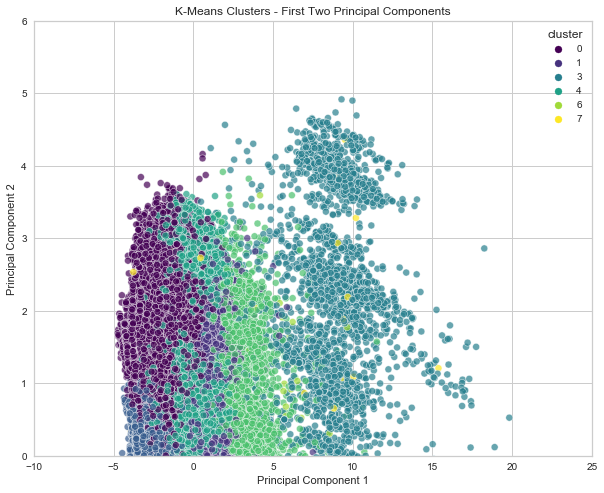

In [168]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_df['cluster'], palette='viridis', alpha=0.7)
plt.title('K-Means Clusters - First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.xlim(-10, 25)
plt.ylim(0, 6)
plt.show()

In [169]:
cluster1 = cluster_df[cluster_df['cluster'] == 0]
cluster2 = cluster_df[cluster_df['cluster'] == 1]
cluster3 = cluster_df[cluster_df['cluster'] == 2]
cluster4 = cluster_df[cluster_df['cluster'] == 3]
cluster5 = cluster_df[cluster_df['cluster'] == 4]
cluster6 = cluster_df[cluster_df['cluster'] == 5]
cluster6 = cluster_df[cluster_df['cluster'] == 6]
cluster6 = cluster_df[cluster_df['cluster'] == 7]

1 = Standard rate\
2 = JFK\
3 = Newark \
4 = Nassau or Westchester \
5 = Negotiated fare \
6 = Group ride

In [170]:
cluster_means = cluster_df[['trip_distance', 'fare_amount', 'tip_amount', 
                            'total_amount', 'trip_duration', 'cluster']]
cluster_means = cluster_means.groupby('cluster').mean()
print(cluster_means)

         trip_distance  fare_amount  tip_amount  total_amount  trip_duration
cluster                                                                     
0             5.926914    23.235550    3.736456     28.641918    1922.364288
1            10.658368    34.702259    8.087634     48.468066    1924.324146
2             6.050532    23.110117    2.946115     27.574282    1931.357212
3            16.305921    69.089229   12.870626     95.246230    1946.417087
4             8.146133    28.510365    4.504549     34.802932    1937.072528
5            18.365827    54.063687    8.149629     67.400015    1959.313603
6             8.285789    65.681053    6.200000     72.038947    1777.105263
7             8.863385    30.452050    5.379286     39.118012   83262.489130


In [171]:
cluster_means = cluster_df[['trip_distance', 'fare_amount', 'tip_amount', 
                            'total_amount', 'trip_duration', 'cluster']]
cluster_means = cluster_means.groupby('cluster').median()
print(cluster_means)

         trip_distance  fare_amount  tip_amount  total_amount  trip_duration
cluster                                                                     
0                6.140         24.0        4.55         29.75         1823.0
1               10.360         34.0        8.00         47.56         1830.0
2                6.300         24.0        3.46         29.16         1833.0
3               17.240         68.0       15.00         96.30         1832.0
4                7.720         27.0        5.05         33.50         1836.0
5               18.150         52.0       10.28         67.30         1846.0
6                0.650         68.0        0.00         71.30         1458.0
7                8.425         28.0        5.36         35.30        85025.0


In [172]:
cluster_means = cluster_df[['tolls_amount', 'payment_type', 'rate_code', 'cluster']]
cluster_means = cluster_means.groupby('cluster').mean()
print(cluster_means)

         tolls_amount  payment_type  rate_code
cluster                                       
0            0.551457      1.207206   1.006771
1            4.579236      1.011676   1.003588
2            0.384918      1.335681   1.007294
3           12.733275      1.120439   3.343222
4            0.605544      1.176498   1.005253
5            3.702119      1.217372   1.703922
6            0.000000      1.157895   3.368421
7            2.142034      1.183230   1.130435


In [173]:
cluster_means = cluster_df[['tolls_amount', 'payment_type', 'rate_code', 'cluster']]
cluster_means = cluster_means.groupby('cluster').median()
print(cluster_means)

         tolls_amount  payment_type  rate_code
cluster                                       
0                0.00           1.0        1.0
1                5.76           1.0        1.0
2                0.00           1.0        1.0
3               12.50           1.0        3.0
4                0.00           1.0        1.0
5                5.76           1.0        2.0
6                0.00           1.0        5.0
7                0.00           1.0        1.0


In [174]:
# Select the relevant columns
cluster_modes = cluster_df[['tolls_amount', 'payment_type', 'rate_code', 'cluster']]
cluster_modes = cluster_modes.groupby('cluster').agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
cluster_modes

tolls_amount  payment_type  rate_code
cluster                                       
0                0.00             1          1
1                5.76             1          1
2                0.00             1          1
3               10.50             1          3
4                0.00             1          1
5                5.76             1          2
6                0.00             1          5
7                0.00             1          1

In [175]:
cluster1['trip_duration'].describe()

count    32639.000000
mean      1922.364288
std        968.942751
min          1.000000
25%       1394.000000
50%       1823.000000
75%       2339.000000
max      42610.000000
Name: trip_duration, dtype: float64

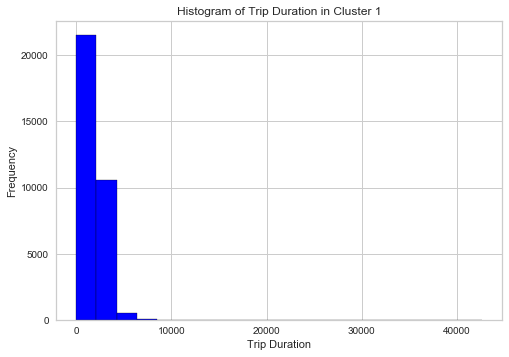

In [176]:
plt.hist(cluster1['trip_duration'], bins=20, color='blue', edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Trip Duration')
plt.ylabel('Frequency')
plt.title('Histogram of Trip Duration in Cluster 1')
plt.show()

In [177]:
# You can analyze the clusters further based on your business logic and requirements

In [178]:
fdf.dtypes

trip_distance              float64
rate_code                    int64
store_and_fwd_flag          object
payment_type                 int64
fare_amount                float64
extra                      float64
mta_tax                    float64
tip_amount                 float64
tolls_amount               float64
imp_surcharge              float64
total_amount               float64
pickup_location_id           int64
dropoff_location_id          int64
month                        int64
day                          int64
day_of_week                  int64
hour_of_day                  int64
trip_duration              float64
calculated_total_amount    float64
pickup_zone_id               int64
pickup_zone_name            object
pickup_borough              object
pickup_zone_geom            object
dropoff_zone_id              int64
dropoff_zone_name           object
dropoff_borough             object
dropoff_zone_geom           object
dtype: object

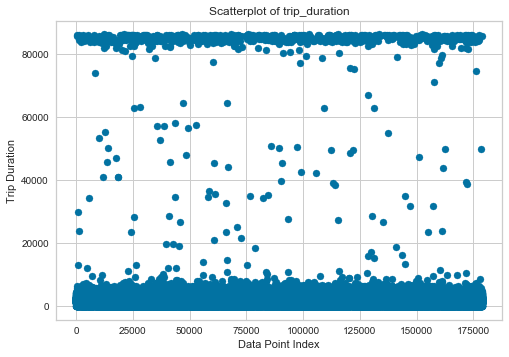

In [179]:
# Assuming 'trip_duration' is the column you want to plot
plt.scatter(range(len(cluster_df['trip_duration'])), cluster_df['trip_duration'])
plt.xlabel('Data Point Index')
plt.ylabel('Trip Duration')
plt.title('Scatterplot of trip_duration')
plt.show()

# Model Comparison

|                    | Linear Regression | Lasso Regression | Ridge Regression | Elastic Net | Random Forest | FNN | XGBoost |
|--------------------|----------|----------|----------|----------|----------|----------|----------|
| Training RMSE Loss | 5.495  | 5.728  | 5.495  | 6.006  | 1.922  | 20.661  | 1.922  |
| Testing RMSE Loss  | 5.650  | 5.860  | 5.650  | 6.144  | 3.997  | 4.528  | 3.904  |
|       R^2          | 0.893  | 0.885  | 0.893  | 0.874  | 0.947  | 0.932  | 0.949  |


We can see that Random forest and XGBoost have the lowest RMSE Loss, and XGBoost has the lowest testing RMSE Loss. XGBoost also has the highest R^2 score. Given this performance matrix, we can say that among the models that we have used in this project, XGBoost has the best performance.

# Challenges and Limitations

Overall, we were able to gain a lot of insight into the relationships between features and how they influence price of taxis. We were also able to develop machine learning models that generalized well with our data. However, there are challenges and limitations to our analysis that are important to acknowledge. First, the dataset only contains taxi data from 2018. Data from a larger time period, like across multiple years, would allow for a more robust time-series analysis and maybe allow us to identify seasonal changes in price of taxis. But since the data is only from one year, we focused our analysis mainly on factors unrelated to time, like location and distance.  

Another challenge we faced was the large number of pickup and dropoff zones. While we were able to one-hot encode boroughs, there were too many different zones, so we had to resort to frequency encoding. Although frequency encoding allows us to factor in how common or high-demand a location is, it still causes us to lose potentially valuable information like how price varies across specific zones. 

# Future Work

There are a few next steps we envision implementing to build upon our analysis for this project. First, although the data was limited to one year, there are still time-related variables like month, day, and hour. A next step could be to incorporate time-series analysis to some extent, such as using reucrrent neural networks to capture temporal trends within that year. 

Another next step could be conduct deeper analysis on the relationship between geospatial information and total price. While we did make use of variables like borough and zones, we did not incorporate the geometric outline variable. With more preprocessing and in-depth analysis, this variable could potentially reveal more information on how prices vary across different areas. 

Finally, in terms of additional data that could be used to supplement the current dataset, we think text data, such as rider reviews and information on relevant areas/neighborhoods, could be very insightful. The text data could be analyzed using natural language processing, deepening the complexity of our analysis. 